In [1]:
from fastai.vision.all import *
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from sklearn.model_selection import train_test_split
from timm import create_model
from fastai.vision.learner import _update_first_layer
from sklearn.metrics import roc_auc_score

In [2]:
path = Path('/home/azaidi/Desktop/kaggle/seti_2021')
Path.BASE_PATH = path
path.ls()

(#16) [Path('kfold.ipynb'),Path('res50.ipynb'),Path('data'),Path('kf_sesresnext.ipynb'),Path('aug_training.ipynb'),Path('models'),Path('.git'),Path('3_arch_big.ipynb'),Path('initial.ipynb'),Path('.gitignore')...]

In [3]:
train_df = pd.read_csv(path/'data/train_labels.csv')
sub_df = pd.read_csv(path/'data/sample_submission.csv')
train_df.shape

(50165, 2)

In [4]:
data_path = path/'data'
train_df['path'] = train_df['id'].apply(lambda x: str(data_path/'train'/x[0]/x)+'.npy')

In [5]:
class SetiDS(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        target = self.df.iloc[idx].target
        path = self.df.iloc[idx].path
        
        #the samples are all a 6x273x256 matrix
        x = np.load(path).astype(np.float32)[[0,2,4]] #3x273x256
        x = np.vstack(x)  #819x256
        x = x.transpose((1,0)) # 256x1638 now
        
        if self.transforms:
            x = self.transforms(image=x)['image']
        
        x = torch.tensor(x).float().unsqueeze(0)
        
        return x, torch.tensor(target)

In [6]:
train_tfm = A.Compose([
    A.Resize(512,512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomResizedCrop(320,320)
])

In [7]:
valid_tfm = A.Compose([
    A.Resize(512,512),
])

In [20]:
t_df, v_df = train_test_split(train_df, test_size=0.1)

In [23]:
bs = 256
t_ds = SetiDS(t_df, train_tfm)
v_ds = SetiDS(v_df, valid_tfm)
train_dl = DataLoader(t_ds, batch_size=bs,
                     num_workers=8)
valid_dl = DataLoader(v_ds, batch_size=bs,
                     num_workers=8)

dls = DataLoaders(train_dl, valid_dl)

In [ ]:
t_ds[0][0].shape

In [25]:
def roc_auc(preds,targ):
    try: return roc_auc_score(targ.cpu(),preds.squeeze().cpu())
    except: return 0.5

In [26]:
def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")
        
def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=True, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from the `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children()))
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model.to('cuda')

def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_in=3, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, n_in=n_in, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

In [34]:
learn = timm_learner(dls,'resnet18d',pretrained=True,
                     n_in=1,n_out=1,metrics=[roc_auc], 
                     opt_func=ranger,
                     loss_func=BCEWithLogitsLossFlat()).to_fp16()

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.17378008365631104)

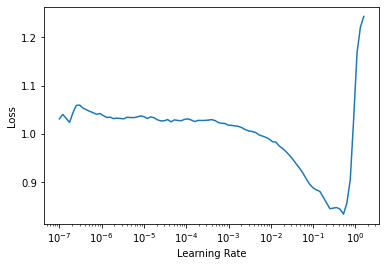

In [35]:
learn.lr_find()

In [36]:
learn.fit_flat_cos(1, 3e-2, wd=0.1)

epoch,train_loss,valid_loss,roc_auc,time
0,0.288996,0.256180,0.815506,00:58


SuggestedLRs(lr_min=0.002754228748381138, lr_steep=7.585775847473997e-07)

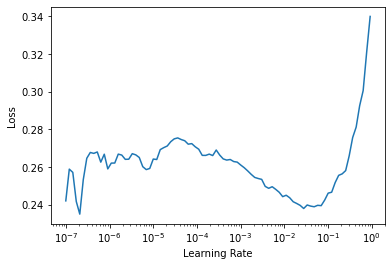

In [37]:
learn.unfreeze()
learn.lr_find()

In [38]:
learn.fit_flat_cos(7, 3e-3, wd=0.1, cbs=[ReduceLROnPlateau()])

epoch,train_loss,valid_loss,roc_auc,time
0,0.149776,0.079056,0.965379,01:19
1,0.130936,0.127314,0.952094,01:19
2,0.124194,0.057089,0.975445,01:19
3,0.116346,0.183811,0.968172,01:19
4,0.113877,0.067369,0.977612,01:19
5,0.108765,0.055490,0.981509,01:19
6,0.096821,0.046119,0.985942,01:19


Epoch 1: reducing lr to 0.00030000000000000003
Epoch 3: reducing lr to 0.00030000000000000003
Epoch 4: reducing lr to 0.00030000000000000003


In [39]:
learn.save('res18d-ft')

Path('models/res18d-ft.pth')

In [33]:
learn = timm_learner(dls,'resnet18d',pretrained=True,
                     n_in=1,n_out=1,metrics=[roc_auc], 
                     opt_func=ranger,
                     loss_func=BCEWithLogitsLossFlat()).to_fp16()

epoch,train_loss,valid_loss,roc_auc,time
0,0.357332,0.351738,0.604058,00:59


epoch,train_loss,valid_loss,roc_auc,time
0,0.235989,0.203656,0.876925,01:20
1,0.182803,0.148902,0.924276,01:20
2,0.150579,0.104676,0.942125,01:20
3,0.141344,0.089206,0.944833,01:20
4,0.129850,0.074817,0.968444,01:20
5,0.123693,0.070828,0.973325,01:20
6,0.112816,0.067522,0.971098,01:20
7,0.111318,0.059444,0.977235,01:20
8,0.110011,0.069837,0.976671,01:20
9,0.104100,0.048599,0.980003,01:20


Epoch 8: reducing lr to 0.0021423088753885658
Epoch 10: reducing lr to 0.0011134314779354993
Epoch 11: reducing lr to 0.0006612354473945006
Epoch 12: reducing lr to 0.00030578246882233056
Epoch 14: reducing lr to 3.750006007802176e-08


In [10]:
train_tfm = A.Compose([
    #A.Resize(512,512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
])

valid_tfm = A.Compose([
    #A.Resize(512,512),
])
bs= 32
t_ds = SetiDS(t_df, train_tfm)
v_ds = SetiDS(v_df, valid_tfm)
train_dl = DataLoader(t_ds, batch_size=bs,
                     num_workers=8)
valid_dl = DataLoader(v_ds, batch_size=bs,
                     num_workers=8)

dls = DataLoaders(train_dl, valid_dl)

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.43651583790779114)

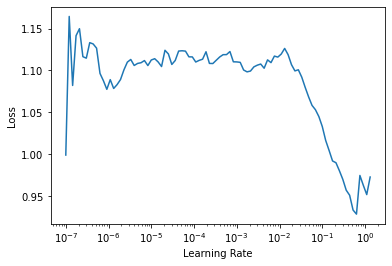

In [14]:
learn = timm_learner(dls,'efficientnet_b0',pretrained=True,
                     n_in=1,n_out=1,metrics=[roc_auc], 
                     opt_func=ranger,
                     loss_func=BCEWithLogitsLossFlat()).to_fp16()
learn.lr_find()

In [15]:
learn.fit_flat_cos(10, 7e-2, wd=0.1, cbs=[ReduceLROnPlateau()])

epoch,train_loss,valid_loss,roc_auc,time
0,0.187217,0.174584,0.917199,05:25
1,0.158668,0.207006,0.920717,05:18
2,0.167266,nan,0.821718,05:18
3,0.153356,nan,0.829576,05:18
4,0.151000,nan,0.854057,05:18
5,0.158198,nan,0.773688,05:19
6,0.141247,nan,0.836926,05:18
7,0.131324,nan,0.731522,05:18
8,0.100322,nan,0.829347,05:19
9,0.086152,nan,0.820819,05:19


Epoch 1: reducing lr to 0.007000000000000001
Epoch 2: reducing lr to 0.007000000000000001
Epoch 3: reducing lr to 0.007000000000000001


/home/azaidi/anaconda3/envs/fastai/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Epoch 4: reducing lr to 0.007000000000000001


/home/azaidi/anaconda3/envs/fastai/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Epoch 5: reducing lr to 0.007000000000000001


/home/azaidi/anaconda3/envs/fastai/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Epoch 6: reducing lr to 0.007000000000000001
Epoch 7: reducing lr to 0.006333624610133289
Epoch 8: reducing lr to 0.002421818811114261
Epoch 9: reducing lr to 7.175499716904898e-08
